# Import libraries

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import datasets

In [3]:
train = pd.read_excel('/kaggle/input/predict-food-delivery-time/Data_Train.xlsx')
test = pd.read_excel('/kaggle/input/predict-food-delivery-time/Data_Test.xlsx')

In [4]:
train.shape, test.shape

((11094, 9), (2774, 8))

# Data exploration

In [5]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [6]:
train.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 9 columns):
Restaurant       11094 non-null object
Location         11094 non-null object
Cuisines         11094 non-null object
Average_Cost     11094 non-null object
Minimum_Order    11094 non-null object
Rating           11094 non-null object
Votes            11094 non-null object
Reviews          11094 non-null object
Delivery_Time    11094 non-null object
dtypes: object(9)
memory usage: 780.2+ KB


In [8]:
train.nunique()

Restaurant       7480
Location           35
Cuisines         2179
Average_Cost       26
Minimum_Order      18
Rating             33
Votes            1103
Reviews           761
Delivery_Time       7
dtype: int64

In [9]:

train['Delivery_Time'].value_counts()

30 minutes     7406
45 minutes     2665
65 minutes      923
120 minutes      62
20 minutes       20
80 minutes       14
10 minutes        4
Name: Delivery_Time, dtype: int64

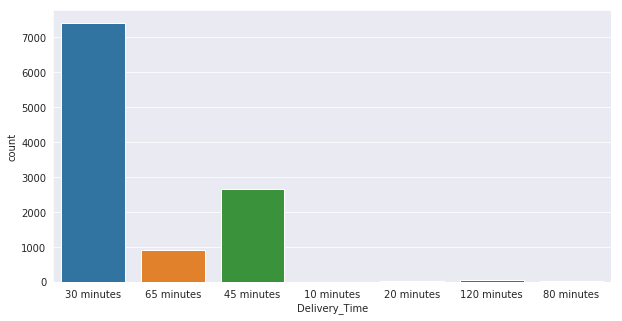

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x='Delivery_Time', data=train)

# Data pre-processing

In [11]:
train = train[train['Delivery_Time'] != '10 minutes']
train.shape

(11090, 9)

In [12]:
df = train.append(test,ignore_index=True, sort=False)
df.shape

(13864, 9)

In [13]:
df['Restaurant'] = df['Restaurant'].astype('category')

In [14]:
df.head(1)

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes


In [15]:
df['Cuisines'] = df['Cuisines'].str.replace('Poké','Poke')
df['Cuisines'] = df['Cuisines'].str.replace('Coffee','Tea')
df['Cuisines'] = df['Cuisines'].str.replace('Hyderabadi','Biryani')

df['Cuisines'] = df['Cuisines'].str.replace('Assamese','North Eastern')
#df['Cuisines'] = df['Cuisines'].str.replace('Naga','North Eastern')

cuisines_list = df['Cuisines'].str.split(', ')

from collections import Counter
cuisines_counter = Counter(([a for b in cuisines_list.tolist() for a in b]))

for cuisine in cuisines_counter.keys():
    df[cuisine] = 0
    df.loc[df['Cuisines'].str.contains(cuisine), cuisine] = 1

In [16]:
df['Location'] = df['Location'].str.replace('Sector 63A,Gurgaon', 'Sector 63A, Gurgaon') 
df['Location'] = df['Location'].str.replace('BTM Layout,Bangalore', 'BTM Layout, Bangalore')
df['Location'] = df['Location'].str.replace('Majestic', 'Majestic, Bangalore')

location_list = df['Location'].str.split(', ') 

from collections import Counter
location_counter = Counter(([a for b in location_list.tolist() for a in b]))

for loc in location_counter.keys():
    df[loc] = 0
    df.loc[df['Location'].str.contains(loc), loc] = 1

In [17]:
df['Average_Cost'] = df['Average_Cost'].str.replace('for','-999')
df['Average_Cost'] = df['Average_Cost'].str.replace(',','')
df['Average_Cost'] = df['Average_Cost'].str.replace('₹','').astype(float)
df['Average_Cost'] = df['Average_Cost'].replace('-999',np.NaN) 

In [18]:
df['Minimum_Order'] = df['Minimum_Order'].str.replace('₹','').astype(float)

In [19]:
df['Rating1'] = df['Rating'].str.replace('-','-999')
df['Rating1'] = df['Rating1'].str.replace('NEW','-999')
df['Rating1'] = df['Rating1'].str.replace('Opening Soon','-999')
df['Rating1'] = df['Rating1'].str.replace('Temporarily Closed','-999')
df['Rating1'] = df['Rating1'].astype(float)
df['Rating1'] = df['Rating1'].replace(-999,np.NaN)

agg_func = {
    'Rating1': ['mean','median','min','max','sum']
}
agg_restaurant = df.groupby('Restaurant').agg(agg_func)
agg_restaurant.columns = [ 'Restaurant_' + ('_'.join(col).strip()) for col in agg_restaurant.columns.values]
agg_restaurant.reset_index(inplace=True)
df = df.merge(agg_restaurant, on=['Restaurant'], how='left')

In [20]:
df['Cat_Rating1'] = pd.qcut(df['Rating1'],q=5,labels=False)

In [21]:
df['Rating'] = df['Rating'].astype('category')

In [22]:
df['Votes'] = df['Votes'].str.replace('-','-999')
df['Votes'] = df['Votes'].astype(float)
df['Votes'] = df['Votes'].replace(-999,np.NaN)

In [23]:
df['Reviews'] = df['Reviews'].str.replace('-','-999')
df['Reviews'] = df['Reviews'].astype(float)
df['Reviews'] = df['Reviews'].replace(-999,np.NaN)

In [24]:
calc = df.groupby(['Restaurant'], axis=0).agg({'Restaurant':[('op1', 'count')]}).reset_index() 
calc.columns = ['Restaurant','Restaurant Count']
df = df.merge(calc, on=['Restaurant'], how='left')

In [25]:
agg_func = {
    'Votes': ['mean','median','min','max','sum'],
    'Reviews': ['mean','median','min','max','sum']
}
agg_restaurant = df.groupby('Restaurant').agg(agg_func)
agg_restaurant.columns = [ 'Restaurant_' + ('_'.join(col).strip()) for col in agg_restaurant.columns.values]
agg_restaurant.reset_index(inplace=True)
df = df.merge(agg_restaurant, on=['Restaurant'], how='left')

In [26]:
df.head(1)

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,Fast Food,Rolls,Burger,Salad,Wraps,Ice Cream,Desserts,Italian,Street Food,Mughlai,North Indian,Chinese,Cafe,Beverages,South Indian,Thai,Asian,Mithai,Momos,Indonesian,Biryani,Kerala,Bihari,Mexican,Japanese,Bakery,Burmese,Bubble Tea,Tea,Pizza,Lucknowi,Mangalorean,European,Continental,Sandwich,Healthy Food,Bengali,American,Mishti,Andhra,North Eastern,Maharashtrian,German,Arabian,Finger Food,Kebab,Chettinad,Seafood,Juices,Parsi,Sushi,Odia,Tamil,Cantonese,Tibetan,Lebanese,Spanish,Bar Food,Konkan,Paan,Steak,Mediterranean,Bohri,Afghan,Goan,Gujarati,BBQ,Raw Meats,Malaysian,Vietnamese,Sri Lankan,Rajasthani,Poke,Roast Chicken,Brazilian,Belgian,Naga,Korean,Modern Indian,Awadhi,Kashmiri,French,Portuguese,Charcoal Chicken,Frozen Yogurt,Bangladeshi,Malwani,Iranian,Nepalese,Indian,Tex-Mex,Hot dogs,South American,Middle Eastern,African,Turkish,Israeli,Greek,FTI College,Law College Road,Pune,Sector 3,Marathalli,Mumbai Central,Sector 1,Noida,Rmz Centennial,I Gate,Whitefield,Delhi University-GTB Nagar,Yerawada,Maharashtra,Delhi Administration Flats,Timarpur,Moulali,Kolkata,Dockyard Road,Mumbai CST Area,Pune University,Gora Bazar,Rajbari,North Dumdum,D-Block,Sector 63,Sector 14,Mico Layout,Stage 2,BTM Layout,Bangalore,Laxman Vihar Industrial Area,Sector 3A,Gurgoan,Tiretti,Sandhurst Road,MG Road,Hyderabad Public School,Begumpet,Majestic,Chandni Chowk,Delhi High Court,India Gate,Chatta Bazaar,Malakpet,Hyderabad,Sector 63A,Gurgaon,Delhi Cantt.,Tejas Nagar Colony,Wadala West,Mumbai,Babarpur,New Delhi,Delhi,Nathan Road,Mangaldas Road,Panjetan Colony,Raja Bazar,Jaya Nagar,Saidabad,Noorkhan Bazaar,Musi Nagar,BTM Layout 1,Electronic City,Rating1,Restaurant_Rating1_mean,Restaurant_Rating1_median,Restaurant_Rating1_min,Restaurant_Rating1_max,Restaurant_Rating1_sum,Cat_Rating1,Restaurant Count,Restaurant_Votes_mean,Restaurant_Votes_median,Restaurant_Votes_min,Restaurant_Votes_max,Restaurant_Votes_sum,Restaurant_Reviews_mean,Restaurant_Reviews_median,Restaurant_Reviews_min,Restaurant_Reviews_max,Restaurant_Reviews_sum
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200.0,50.0,3.5,12.0,4.0,30 minutes,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.5,3.5,3.5,3.5,3.5,3.5,1.0,1,12.0,12.0,12.0,12.0,12.0,4.0,4.0,4.0,4.0,4.0


In [27]:
from scipy.stats import boxcox

df['Rating1 Log'] = df['Rating1'].apply(np.log)
df['Rating1 Reciprocal'] = 1 / df['Rating1'] 
df['Rating1 Sqrt'] = np.sqrt(df['Rating1'])
df['Rating1 Exp'] = np.exp(df['Rating1'])
df['Rating1 BoxCox'] = boxcox(df['Rating1'])[0]

In [28]:
df.drop(['Cuisines','Location','Rating1'], axis=1, inplace=True)

In [29]:
train_df = df[df['Delivery_Time'].isnull()!=True]
test_df = df[df['Delivery_Time'].isnull()==True]
test_df.drop(['Delivery_Time'], axis=1, inplace=True)

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['Delivery_Time'] = le.fit_transform(train_df['Delivery_Time'])
le.classes_

array(['120 minutes', '20 minutes', '30 minutes', '45 minutes',
       '65 minutes', '80 minutes'], dtype=object)

In [31]:
train_df.shape, test_df.shape

((11090, 187), (2774, 186))

In [32]:
train_df.head(2)

,Restaurant,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,Fast Food,Rolls,Burger,Salad,Wraps,Ice Cream,Desserts,Italian,Street Food,Mughlai,North Indian,Chinese,Cafe,Beverages,South Indian,Thai,Asian,Mithai,Momos,Indonesian,Biryani,Kerala,Bihari,Mexican,Japanese,Bakery,Burmese,Bubble Tea,Tea,Pizza,Lucknowi,Mangalorean,European,Continental,Sandwich,Healthy Food,Bengali,American,Mishti,Andhra,North Eastern,Maharashtrian,German,Arabian,Finger Food,Kebab,Chettinad,Seafood,Juices,Parsi,Sushi,Odia,Tamil,Cantonese,Tibetan,Lebanese,Spanish,Bar Food,Konkan,Paan,Steak,Mediterranean,Bohri,Afghan,Goan,Gujarati,BBQ,Raw Meats,Malaysian,Vietnamese,Sri Lankan,Rajasthani,Poke,Roast Chicken,Brazilian,Belgian,Naga,Korean,Modern Indian,Awadhi,Kashmiri,French,Portuguese,Charcoal Chicken,Frozen Yogurt,Bangladeshi,Malwani,Iranian,Nepalese,Indian,Tex-Mex,Hot dogs,South American,Middle Eastern,African,Turkish,Israeli,Greek,FTI College,Law College Road,Pune,Sector 3,Marathalli,Mumbai Central,Sector 1,Noida,Rmz Centennial,I Gate,Whitefield,Delhi University-GTB Nagar,Yerawada,Maharashtra,Delhi Administration Flats,Timarpur,Moulali,Kolkata,Dockyard Road,Mumbai CST Area,Pune University,Gora Bazar,Rajbari,North Dumdum,D-Block,Sector 63,Sector 14,Mico Layout,Stage 2,BTM Layout,Bangalore,Laxman Vihar Industrial Area,Sector 3A,Gurgoan,Tiretti,Sandhurst Road,MG Road,Hyderabad Public School,Begumpet,Majestic,Chandni Chowk,Delhi High Court,India Gate,Chatta Bazaar,Malakpet,Hyderabad,Sector 63A,Gurgaon,Delhi Cantt.,Tejas Nagar Colony,Wadala West,Mumbai,Babarpur,New Delhi,Delhi,Nathan Road,Mangaldas Road,Panjetan Colony,Raja Bazar,Jaya Nagar,Saidabad,Noorkhan Bazaar,Musi Nagar,BTM Layout 1,Electronic City,Restaurant_Rating1_mean,Restaurant_Rating1_median,Restaurant_Rating1_min,Restaurant_Rating1_max,Restaurant_Rating1_sum,Cat_Rating1,Restaurant Count,Restaurant_Votes_mean,Restaurant_Votes_median,Restaurant_Votes_min,Restaurant_Votes_max,Restaurant_Votes_sum,Restaurant_Reviews_mean,Restaurant_Reviews_median,Restaurant_Reviews_min,Restaurant_Reviews_max,Restaurant_Reviews_sum
0,ID_6321,200.0,50.0,3.5,12.0,4.0,2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.500,3.5,3.5,3.5,3.5,1.0,1,12.00,12.0,12.0,12.0,12.0,4.00,4.0,4.0,4.0,4.0
1,ID_2882,100.0,50.0,3.5,11.0,4.0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.125,3.0,3.0,3.5,12.5,1.0,6,19.25,22.0,11.0,22.0,77.0,9.25,11.0,4.0,11.0,37.0


# Train test split

In [33]:
X = train_df.drop(labels=['Delivery_Time'], axis=1)
y = train_df['Delivery_Time'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [34]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((8317, 186), (8317,), (2773, 186), (2773,))

In [35]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([0, 3])

# Build the model

In [36]:
from math import sqrt 
from sklearn.metrics import accuracy_score

## Catboost

In [37]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=6,
                         random_seed=42, 
                         iterations=1500, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
cat.fit(X_train, y_train, verbose=50,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)

0:	learn: 0.6887099	test: 0.6883492	test1: 0.6923909	best: 0.6923909 (0)	total: 151ms	remaining: 3m 46s
50:	learn: 0.7709511	test: 0.9690994	test1: 0.8088713	best: 0.8088713 (50)	total: 2.7s	remaining: 1m 16s
100:	learn: 0.7823735	test: 0.9794397	test1: 0.8150018	best: 0.8164443 (98)	total: 5.35s	remaining: 1m 14s
150:	learn: 0.7940363	test: 0.9822051	test1: 0.8164443	best: 0.8164443 (98)	total: 8.14s	remaining: 1m 12s
200:	learn: 0.8026933	test: 0.9838884	test1: 0.8153624	best: 0.8168049 (173)	total: 11s	remaining: 1m 11s
250:	learn: 0.8141157	test: 0.9855717	test1: 0.8175261	best: 0.8186080 (220)	total: 13.9s	remaining: 1m 9s
300:	learn: 0.8234940	test: 0.9860527	test1: 0.8193292	best: 0.8207717 (260)	total: 16.7s	remaining: 1m 6s
350:	learn: 0.8311891	test: 0.9883371	test1: 0.8204111	best: 0.8207717 (260)	total: 19.6s	remaining: 1m 4s
400:	learn: 0.8402068	test: 0.9888181	test1: 0.8196899	best: 0.8218536 (360)	total: 22.5s	remaining: 1m 1s
450:	learn: 0.8475412	test: 0.9896597	test1

In [38]:
predictions = cat.predict(X_cv)
print('accuracy:', accuracy_score(y_cv, predictions))

accuracy: 0.8218535881716552


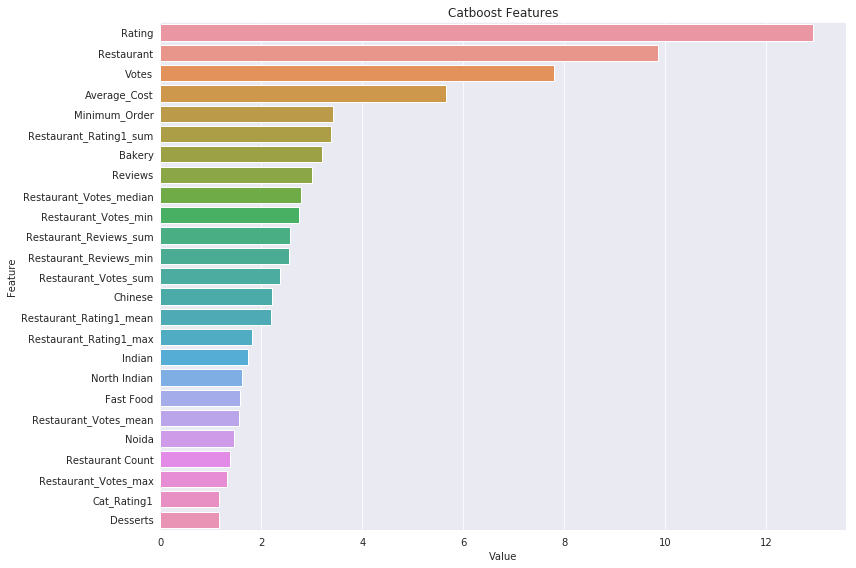

In [39]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:25], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

# Predict on test set

In [40]:
Xtest = test_df

## Catboost

In [41]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=6,
                         random_seed=42, 
                         iterations=1500, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test,y_pred_cat))

    errcat.append(accuracy_score(y_test,y_pred_cat))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Accuracy:  0.8232642019837692
Accuracy:  0.7917042380522994
Accuracy:  0.8313796212804329
Accuracy:  0.8232642019837692
Accuracy:  0.8431018935978359
Accuracy:  0.8277727682596934
Accuracy:  0.8385933273219116
Accuracy:  0.8349864743011722
Accuracy:  0.8440036068530208
Accuracy:  0.8214607754733995


In [42]:
np.mean(errcat,0)

0.8279531109107305

In [43]:
cat_final = np.mean(y_pred_totcat,0).round().astype(int)
cat_final

array([[2],
       [2],
       [2],
       ...,
       [3],
       [2],
       [4]])

# Submission

In [44]:
y_pred_class = le.inverse_transform(cat_final)
df_sub = pd.DataFrame(data=y_pred_class, columns=['Delivery_Time'])
df_sub.head()

,Delivery_Time
0,30 minutes
1,30 minutes
2,30 minutes
3,30 minutes
4,30 minutes


In [45]:
df_sub['Delivery_Time'].value_counts()

30 minutes     2032
45 minutes      614
65 minutes      121
120 minutes       6
80 minutes        1
Name: Delivery_Time, dtype: int64

In [46]:
writer = pd.ExcelWriter('cat52.xlsx', engine='xlsxwriter')
df_sub.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()